# 記事同士の関連の視覚化
記事同士の関連を見つけるためには、

1. 本文全体からキーワードを取り出して比較する
2. 記事情報を頼りにリンクとなりそうなキーワードを取り出して比較する

というようなものがあります。今回は簡単に、関連キーワードを用いてネットワークを作ってみます。


In [1]:
from parse import json_parser
from service import utils, related_words, absts, contents

from boundary.absts import Abst
from boundary.contents import Content
from boundary.dockeywords import DocKeywords
from boundary.keywords import Keyword
from boundary.related_words import Related_Words
from service.contents import SectionTree

from pymongo import MongoClient
from bson.objectid import ObjectId
from getpass import getpass
from pathlib import Path
import pandas as pd

from typing import List, Union, Tuple, Dict

In [2]:
class ParsedArticle:
    def __init__(self, file: Path):
        self.raw_data = json_parser.read_json(file)
        self.title = utils.get_element(self.raw_data, "title")
        self.title_head = utils.get_element(self.raw_data, "title-head")
        self.keywords = utils.get_element(
            self.raw_data, "keywords", 
            message="this article has no keywords")       
        self.raw_related_words, self.related_words = related_words.extract_item(self.raw_data)
        self.related_words_len = len(self.related_words)
        self.abstruct, self.sections = self.parse_article()

    def parse_article(self):
        article = utils.get_element(
            self.raw_data, "article", message="this article has no body")
        import copy
        abstruct, _ ,left = absts.extract_abstruct(article)
        sections, _= contents.SectionParser().parse(left)
        return abstruct, sections

In [3]:
class Boundary:
    def __init__(self, 
            username: str="root", password: str ="passwd", 
            host: str="127.0.0.1", port: int=27017):
        client = MongoClient(host=host, 
            port=port, username=username, password=password)
        self.abst_db = Abst(client)
        self.content_db = Content(client)
        self.keyword_db = Keyword(client)
        self.dockeywords_db = DocKeywords(client)
        self.relatedwords_db = Related_Words(client)

    def reset(self):
        self.abst_db.reset()
        self.content_db.reset()
        self.keyword_db.reset()
        self.dockeywords_db.reset()
        self.relatedwords_db.reset()

    def insert_keyword(
        self, keyword: Union[str, List[str], Tuple[str]]):
        if type(keyword) is str:
            self.keyword_db.insert(keyword)
        elif type(keyword) in [list, tuple]:
            [self.keyword_db.insert(k) for k in keyword]
        else:
            raise NotImplementedError()

    def get_keyword(self, keyword: Union[str, List[str]]):
        if type(keyword) is str:
            return self.keyword_db.find_object(keyword)
        elif type(keyword) is list:
            if type(keyword[0]) is str:
                return [self.keyword_db.find_object(k) 
                        for k in keyword]
            elif type(keyword[0]) is ObjectId:
                return [self.keyword_db.get_by_id(k) 
                        for k in keyword]
        else:
            raise NotImplementedError()

    def recover_keyword(
        self, 
        keyword_id: Union[ObjectId, List[ObjectId]]):
        if type(keyword_id) is ObjectId:
            return self.keyword_db.get_by_id(keyword_id)
        elif type(keyword_id) is list:
            return [self.keyword_db.get_by_id(i) for i in keyword_id]
        else:
            raise NotImplementedError()
    
    def insert_dockeywords(
        self, title: Union[str, ObjectId],
        keywords: Union[List[str], List[ObjectId]]):
        if type(title) is str:
            title = self.get_keyword(title)
        if len(keywords) != 0 and type(keywords[0]) is str:
            keywords = self.get_keyword(keywords)
        self.dockeywords_db.insert(title, keywords)

    def insert_relatedwords(
        self, title: Union[str, ObjectId],
        related_words: Union[List[str], List[ObjectId]],
        raw_related_words: Dict):
        if type(title) is str:
            title = self.get_keyword(title)
        if len(related_words) != 0 and type(related_words[0]) is str:
            related_words = self.get_keyword(related_words)
        self.relatedwords_db.insert(
            title,
            related_words,
            raw_related_words)
    def insert_abstruct(
        self, title: Union[str, ObjectId], abstruct: Dict):
        if type(title) is str:
            title = self.get_keyword(title)
        self.abst_db.insert(title, abstruct)

    def insert_sections(
        self, title: Union[str, ObjectId], 
        sections: List[SectionTree]):
        if type(title) is str:
            title = self.get_keyword(title)
        for sec in sections:
            self.content_db.insert(
                title,
                sec.titles,
                sec.contents)
    
    def insert_article(
        self, article: ParsedArticle):
        self.insert_keyword(article.title)
        self.insert_keyword(article.related_words)
        self.insert_keyword(article.keywords)
        for sec in article.sections:
            self.insert_keyword(sec.titles)
        self.insert_dockeywords(
            article.title,
            article.keywords)
        self.insert_relatedwords(
            article.title,
            article.related_words,
            article.raw_related_words)
        self.insert_abstruct(
            article.title,
            article.abstruct)
        self.insert_sections(
            article.title,
            article.sections)

    @property
    def info(self):
        return {
            "abst": len(self.abst_db),
            "content": len(self.content_db),
            "keyword": len(self.keyword_db),
            "dockeywords": len(self.dockeywords_db),
            "relatedwords": len(self.relatedwords_db)}
    def __repr__(self):
        return str(self.info)
    

In [4]:
username="root"
password=getpass()

In [5]:
bound = Boundary(username=username, password=password)
pd.DataFrame(bound.info.values(), index=bound.info.keys(), columns=["value"])

,value
abst,10
content,36
keyword,217
dockeywords,10
relatedwords,10


まず、記事タイトルを取得します。

In [6]:
titles = []
parent = Path("./resources/")
for path in parent.glob("*.json"):
    art = ParsedArticle(path)
    titles.append(art.title)
print("{} -> {}".format(titles, bound.get_keyword(titles)))

['鈴原るる', 'カニ', 'コアラ', 'キツネ', 'エビ', '三枝明那', 'イルカ', 'でびでび・でびる', '馬', 'エクス・アルビオ'] -> [ObjectId('5e6b2cd776f067320b2bbddf'), ObjectId('5e6b2cd776f067320b2bbe88'), ObjectId('5e6b2cd776f067320b2bbee2'), ObjectId('5e6b2cd776f067320b2bbf2d'), ObjectId('5e6b2cd776f067320b2bbe8e'), ObjectId('5e6b2cd876f067320b2bbfed'), ObjectId('5e6b2cd876f067320b2bc088'), ObjectId('5e6b2cd776f067320b2bbe2f'), ObjectId('5e6b2cd876f067320b2bc193'), ObjectId('5e6b2cd876f067320b2bc044')]


次に、それぞれの関連語を持ってきます。

In [34]:
rws = []
for title, title_id in zip(titles, bound.get_keyword(titles)):
    rwi = bound.relatedwords_db.find_objects(title_id)
    rws.append([title, {"idx": title_id, "related_words": bound.get_keyword(rwi["words"])}])

登場する全ての語について、その参照回数を辞書にします。(擬似的な記事の影響力を考えることが出来ます。)

In [8]:
word_dictionary = {}
for rw in rws:
    for w in rw[1]['related_words']:
        word_dictionary[w['_id']] = (w['keyword'], w['reference'])

for title, title_id in zip(titles, bound.get_keyword(titles)):
    word_dictionary[title_id] = (title, bound.keyword_db.get_by_id(title_id)['reference'])

print(len(word_dictionary))
dict((idx, v) for idx, v in list(word_dictionary.items())[0:3])

134


{ObjectId('5e6b2cd776f067320b2bbde2'): ('いちから株式会社', 4),
 ObjectId('5e6b2cd776f067320b2bbde5'): ('🌖夢月ロア', 3),
 ObjectId('5e6b2cd776f067320b2bbde8'): ('🌶三枝明那', 2)}

## NetworkX を用いた視覚化
グラフの視覚化には NetworkX を用います。

今回は
- 「ノード」を「単語」
- 「エッジ」を「記事から単語への参照」 (今回は記事数が少ないので無向とした)
- 「ノードサイズ」を「単語の参照回数」

とします。エッジの太さについては、今回関連単語という集合を用いているので全て等しい太さ (=1) になります。

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

まずグラフを作り、ノードとエッジを登録します。

In [10]:
G = nx.Graph()
G.clear()
ws = set([])
for word in word_dictionary.values():
    # 出現頻度の低い単語については、枝狩りを行う
    if word[1] > 3:
        ws.add(word[0])
        G.add_node(word[0], attr={"count": word[1]})

for title in titles:
    ws.add(title)
    G.add_node(title, attr={"count": bound.keyword_db.get_by_id(bound.get_keyword(title))['reference']})


for rw in rws:
    title = rw[0]
    for w in rw[1]['related_words']:
        if w['keyword'] in ws:
            G.add_edge(title, w['keyword'], attr={"weight" : 1})

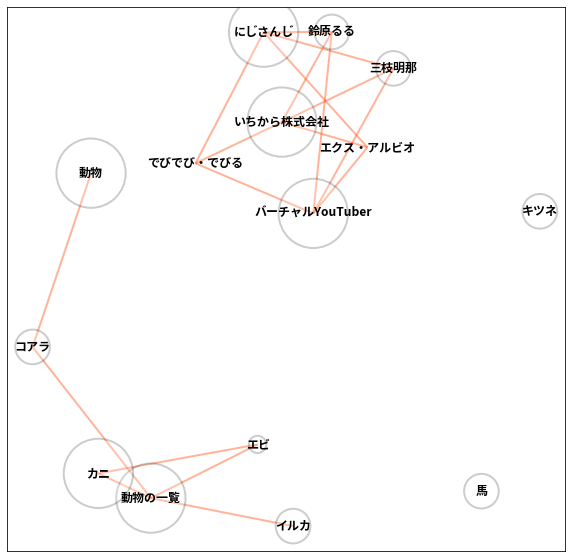

In [12]:
def plot_graph(G: nx.Graph, figsize: Tuple = (10, 10)):
    plt.figure(figsize=figsize)
    pos  = nx.spring_layout(G, k=1)
    node_size = [d['attr']['count'] ** 2 * 300 for n, d in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos=pos, alpha=0.2, node_color="white", node_size=node_size, node_shape='o', linewidths=2.0, edgecolors="black")
    nx.draw_networkx_labels(G, pos=pos, alpha=1.0, font_color="black", font_family="Source Han Sans JP",font_weight="bold")
    nx.draw_networkx_edges(G, pos=pos, alpha=0.4, edge_color='orangered', width=2, arrowstyle="-|>", arrowsize=30, direct=True)
    plt.show()

plot_graph(G)

大分綺麗に分かれていることが確認できると思います。    
念の為、次にコミュニティ検出を行ってみます。

In [11]:
community = nx.algorithms.community.greedy_modularity_communities(G)
from pprint import pprint
pprint([c for c in community])

[frozenset({'いちから株式会社',
            'でびでび・でびる',
            'にじさんじ',
            'エクス・アルビオ',
            'バーチャルYouTuber',
            '三枝明那',
            '鈴原るる'}),
 frozenset({'エビ', '動物の一覧', 'イルカ', 'カニ', '動物', 'コアラ'}),
 frozenset({'キツネ'}),
 frozenset({'馬'})]


上記の例では、

- 視覚的なコミュニティ検出はかなり出来ている
- しかし幾つかのリンク不足の記事は孤立してしまっている

ことがわかると思います。    
これは枝狩りのかなり貢献しています。ここで比較として、枝狩りをしない場合のグラフ、コミュニティを調べてみます。

### 枝狩り = 0 のケース

In [13]:
def generate_graph(freq: int = 0):
    G = nx.Graph()
    G.clear()
    ws = set([])
    for word in word_dictionary.values():
        # 出現頻度の低い単語については、枝狩りを行う
        if word[1] > freq:
            ws.add(word[0])
            G.add_node(word[0], attr={"count": word[1]})

    for title in titles:
        ws.add(title)
        G.add_node(title, attr={"count": bound.keyword_db.get_by_id(bound.get_keyword(title))['reference']})


    for rw in rws:
        title = rw[0]
        for w in rw[1]['related_words']:
            if w['keyword'] in ws:
                G.add_edge(title, w['keyword'], attr={"weight" : 1})
    return G

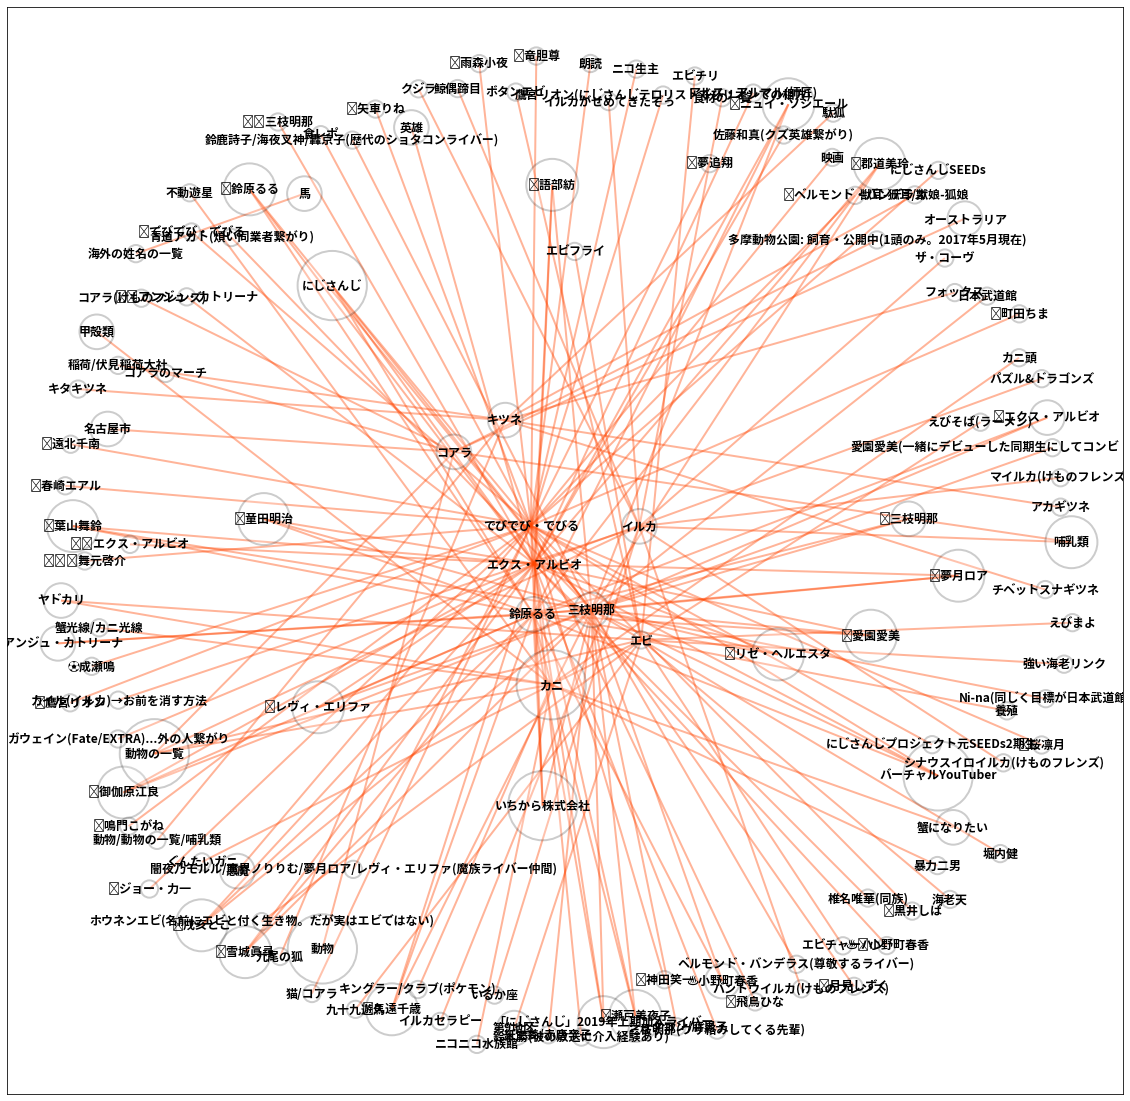

In [38]:
G = generate_graph(0)
plot_graph(G, figsize=(20, 20))

In [39]:
community = nx.algorithms.community.greedy_modularity_communities(G)
from pprint import pprint
pprint([c for c in community])

[frozenset({'Ni-na(同じく目標が日本武道館)',
            '♨小野町春香',
            '♨️小野町春香',
            '⚖アンジュ・カトリーナ',
            '⚖️アンジュ・カトリーナ',
            '「にじさんじ」2019年上期加入ライバー',
            'いちから株式会社',
            'にじさんじ',
            'アルス・アルマル(師匠)',
            'エクス・アルビオ',
            'ガウェイン(Fate/EXTRA)...外の人繋がり',
            'ショタコン/腐男子',
            'バーチャルYouTuber',
            'パズル&ドラゴンズ',
            'ベルモンド・バンデラス(尊敬するライバー)',
            '三枝明那',
            '三枝明那(ウザ絡みしてくる先輩)',
            '佐藤和真(クズ英雄繋がり)',
            '堀内健',
            '愛園愛美(一緒にデビューした同期生にしてコンビ『紅ズワイガニ』の相方)',
            '日本武道館',
            '椎名唯華(同族)',
            '紅生姜/赤唐辛子',
            '英雄',
            '鈴原るる',
            '鈴鹿詩子/海夜叉神/轟京子(歴代のショタコンライバー)',
            '青道アカト(煩い同業者繋がり)',
            '🌐雪城眞尋',
            '🌖夢月ロア',
            '🌶三枝明那',
            '🌶️三枝明那',
            '🍃葉山舞鈴',
            '🍹戌亥とこ',
            '🎃ニュイ・ソシエール',
            '🎨鈴原るる',
            '🏰御伽原江良',
            '🐺童

コミュニティ検出としては、ある程度以前のものと同様のものが検出できていることが確認できると思います。    
※にじさんじのグループが二分されている理由は、不均衡なノード数によるものを挙げることが出来ます。    
(新規メンバーに関わる単語が別グループになっています。)

### 枝狩り = 1 のケース

枝狩り = 0 のケースに比べると視覚的にクラスタを確認できると思います。    
しかしクラスタ結果の方はやや悪化しています。(新規メンバーが別のクラスタに属するようになっている)

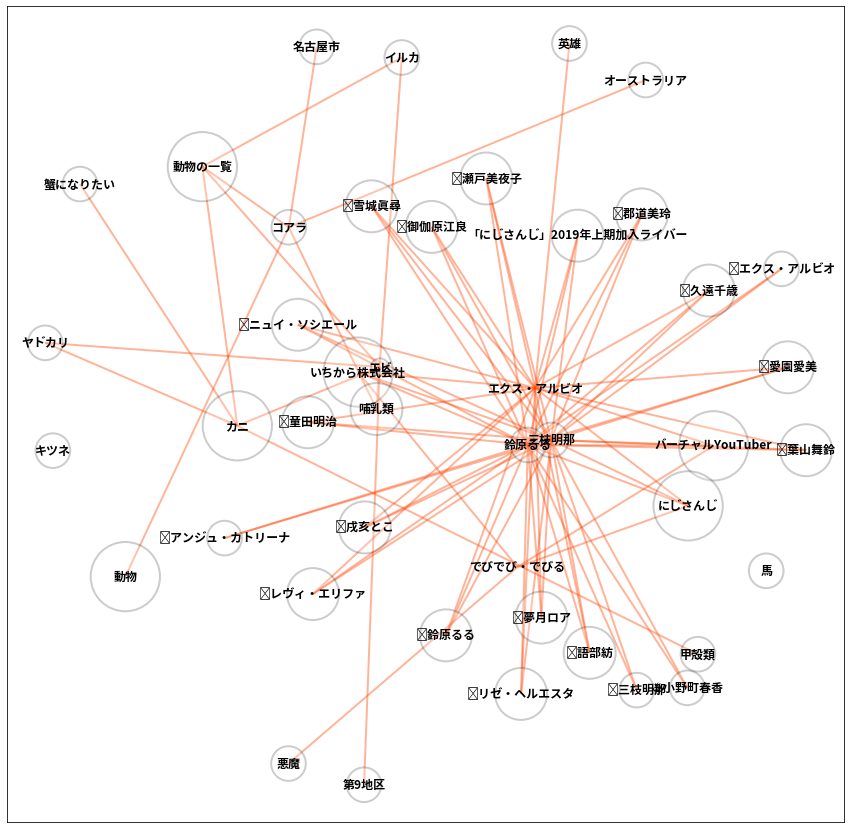

[frozenset({'♨小野町春香',
            '⚖アンジュ・カトリーナ',
            '「にじさんじ」2019年上期加入ライバー',
            '三枝明那',
            '鈴原るる',
            '🌐雪城眞尋',
            '🌖夢月ロア',
            '🌶三枝明那',
            '🍃葉山舞鈴',
            '🍹戌亥とこ',
            '🎨鈴原るる',
            '🏰御伽原江良',
            '🐺童田明治',
            '🐽郡道美玲',
            '👑リゼ・ヘルエスタ',
            '💕愛園愛美',
            '📷瀬戸美夜子',
            '🔲レヴィ・エリファ',
            '🛡エクス・アルビオ',
            '🧂語部紡',
            '🧠久遠千歳'}),
 frozenset({'イルカ',
            'エビ',
            'オーストラリア',
            'カニ',
            'コアラ',
            'ヤドカリ',
            '動物',
            '動物の一覧',
            '名古屋市',
            '哺乳類',
            '甲殻類',
            '第9地区',
            '蟹になりたい'}),
 frozenset({'いちから株式会社',
            'でびでび・でびる',
            'にじさんじ',
            'エクス・アルビオ',
            'バーチャルYouTuber',
            '悪魔',
            '英雄',
            '🎃ニュイ・ソシエール'}),
 frozenset({'キツネ'}),
 frozenset({'馬'})]


In [28]:
G = generate_graph(1)
plot_graph(G, figsize=(15, 15))
community = nx.algorithms.community.greedy_modularity_communities(G)
from pprint import pprint
pprint([c for c in community])

### 枝狩り = 2 のケース
このサイズになると、視覚的にも、クラスタリング結果を見ても良い結果が得られているのではないかと思います。

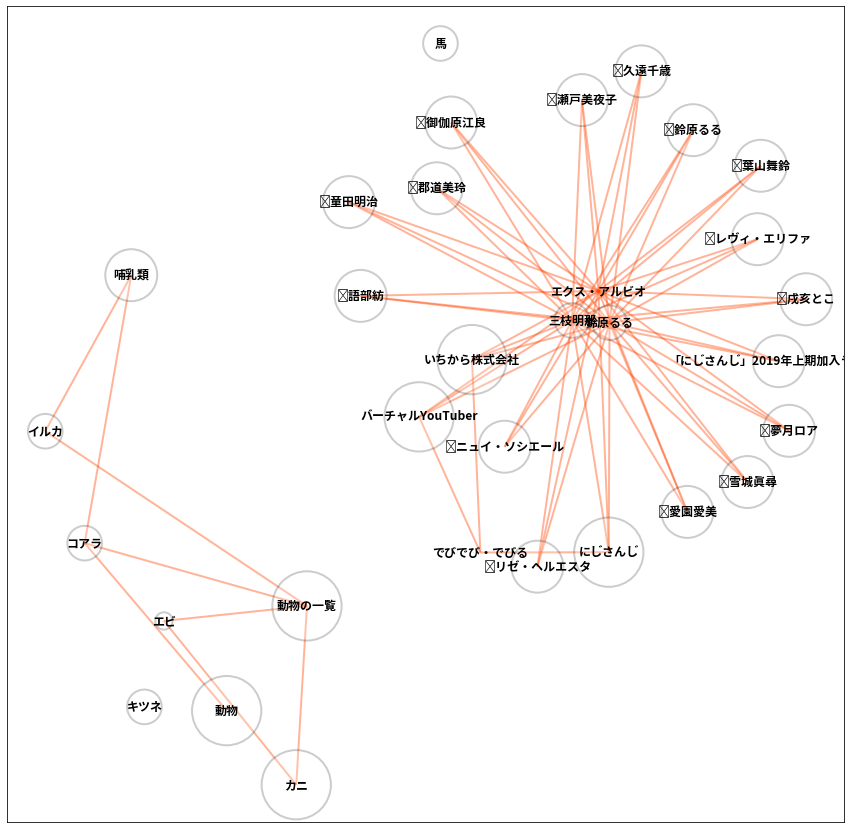

[frozenset({'「にじさんじ」2019年上期加入ライバー',
            'いちから株式会社',
            'でびでび・でびる',
            'にじさんじ',
            'エクス・アルビオ',
            'バーチャルYouTuber',
            '三枝明那',
            '鈴原るる',
            '🌐雪城眞尋',
            '🌖夢月ロア',
            '🍃葉山舞鈴',
            '🍹戌亥とこ',
            '🎃ニュイ・ソシエール',
            '🎨鈴原るる',
            '🏰御伽原江良',
            '🐺童田明治',
            '🐽郡道美玲',
            '👑リゼ・ヘルエスタ',
            '💕愛園愛美',
            '📷瀬戸美夜子',
            '🔲レヴィ・エリファ',
            '🧂語部紡',
            '🧠久遠千歳'}),
 frozenset({'エビ', '動物の一覧', 'イルカ', 'カニ', '哺乳類', '動物', 'コアラ'}),
 frozenset({'キツネ'}),
 frozenset({'馬'})]


In [29]:
G = generate_graph(2)
plot_graph(G, figsize=(15, 15))
community = nx.algorithms.community.greedy_modularity_communities(G)
from pprint import pprint
pprint([c for c in community])

## 文字コードの非統一
特に絵文字などは、同じ文字を異なる文字コードで書く場合があり、これに関してはまっとうな方法では処理することが出来ません。


In [36]:
print('♨小野町春香' =='♨️小野町春香')
print(unicodedata.normalize("NFKC", '♨小野町春香') == unicodedata.normalize("NFKC", '♨️小野町春香'))

False
False
